## Features extractions from images

In [4]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import warnings
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import dataframe_image as dfi
import itertools
import pandas as pd
from PIL import Image
from io import BytesIO
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_features(data_path):
  img_size = (64, 64)
  images = []
  labels = []
  color_features = []
  texture_features = []
  for subdir in os.listdir(data_path):
      subdir_path = os.path.join(data_path, subdir)
      for file_name in os.listdir(subdir_path):
          file_path = os.path.join(subdir_path, file_name)
          img = cv2.imread(file_path)
          img = cv2.resize(img, img_size)

          if img is None:
              print(f"Unable to load image {file_path}")
              continue
          hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
          hist = cv2.normalize(hist, hist).flatten()
          mean_color = cv2.mean(img)[:3]
          mean_color = np.reshape(mean_color, (1, 3))
          std_color = cv2.meanStdDev(img)[:3]
          std_color = std_color[0].reshape((1,3))
          color_moments = np.concatenate([mean_color, std_color], axis=0)
          gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          radius = 3
          n_points = 8 * radius
          lbp = cv2.ORB_create(n_points, radius)
          _, lbp_desc = lbp.compute(gray_img, None)
          distances = [1, 2, 3]
          angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
          glcm = graycomatrix(gray_img, distances, angles, levels=256, symmetric=True, normed=True)
          contrast = graycoprops(glcm, 'contrast')
          dissimilarity = graycoprops(glcm, 'dissimilarity')
          homogeneity = graycoprops(glcm, 'homogeneity')
          contours, _ = cv2.findContours(gray_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          if len(contours) > 0:
              cnt = contours[0]
              moments = cv2.moments(cnt)
              hu_moments = cv2.HuMoments(moments)
              hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
          images.append(img)
          labels.append(subdir)
          color_features.append(np.concatenate([hist, color_moments.flatten()]))
          texture_features.append(hist)
  return images,labels,color_features,texture_features

def generate_dL_results(model, X_test_img, y_test_img, preprocess_input):
    X_test_preprocessed = preprocess_input(X_test_img)
    y_pred_probs = model.predict(X_test_preprocessed)
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test_img)
    num_classes = len(np.unique(y_test_encoded))
    y_true = y_test_encoded

    # ROC Curve and ROC AUC
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--', label='classes')
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_probs[:, i])
        auc = roc_auc_score((y_true == i).astype(int), y_pred_probs[:, i])
        plt.plot(fpr, tpr, label='Class {} (area = {:.3f})'.format(i, auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC & AUC curve for Multiclass Classification')
    plt.legend(loc='best')
    plt.show()
    # plt.savefig(os.path.join(save_training_path, "ROC_AUC.svg"))

def generate_roc_and_auc_graph(y_pred, y_true):
    n_classes = len(np.unique(y_true))
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = 0
    mean_roc_auc = 0

    plt.clf()
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--', label='Classes')
    for i in range(n_classes):
        y_true_binary = (y_true == i).astype(int)
        y_pred_prob = y_pred[:, i] if y_pred.ndim == 2 else y_pred

        fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob)
        roc_auc = roc_auc_score(y_true_binary, y_pred_prob)
        mean_tpr += np.interp(all_fpr, fpr, tpr)
        mean_roc_auc += roc_auc

        plt.plot(fpr, tpr, label='Class {} (area = {:.3f})'.format(i, roc_auc))

    mean_tpr /= n_classes
    mean_roc_auc /= n_classes

    plt.plot(all_fpr, mean_tpr, 'b-', label='Mean ROC (area = {:.3f})'.format(mean_roc_auc))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for Multiclass Classification')
    plt.legend(loc='best')
    # plt.savefig(os.path.join(save_training_path, 'ROC.svg'))
    plt.show()

def generate_results(y_pred,y_true,model_r):
    generate_roc_and_auc_graph(y_pred, y_true)


## Prepare data and define ML & DL models


In [5]:

import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
####
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.model_selection import train_test_split
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121,preprocess_input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder



def feature_data_load(color_features, texture_features, labels):

  # Concatenate the color and texture features
  X = np.concatenate([np.array(color_features), np.array(texture_features)], axis=1)
  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(labels)
  X_train_feature, X_test_feature, y_train_feature, y_test_feature = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train_feature, X_test_feature, y_train_feature, y_test_feature

def random_forest_model(X_train_feature, X_test_feature, y_train_feature, y_test_feature):
  param_grid = {
        'n_estimators': [100],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    }
  print("Training Start with random_forest_model")
  rf_clf = RandomForestClassifier(random_state=42)
  grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
  model_r = grid_search.fit(X_train_feature, y_train_feature)
  best_rf = grid_search.best_estimator_
  rf_pred = best_rf.predict(X_test_feature)
  rf_acc = accuracy_score(y_test_feature, rf_pred)
  # save_training_path = os.path.join("Model_training","random_forest")
  # os.makedirs(save_training_path)
  generate_results(rf_pred,y_test_feature,model_r)
  return rf_acc

def svm_model(X_train_feature, X_test_feature, y_train_feature, y_test_feature):
  param_grid = {
        'C': [1, 10],
        'kernel': ['linear', 'rbf']
    }
  print("Training Start with svm_model")
  clf = SVC()
  grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
  model_r = grid_search.fit(X_train_feature, y_train_feature)
  best_svm = grid_search.best_estimator_
  svm_pred = best_svm.predict(X_test_feature)
  svm_acc = accuracy_score(y_test_feature, svm_pred)
  generate_results(svm_pred,y_test_feature,model_r)
  return svm_acc

def logistic_regression_model(X_train_feature, X_test_feature, y_train_feature, y_test_feature):
  print("Training Start with logistic_regression_model")
  param_grid = {
        'C': [0.1, 10]
    }
  logreg = LogisticRegression(random_state=42, solver='lbfgs', max_iter=20000)
  grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
  model_r = grid_search.fit(X_train_feature, y_train_feature)
  best_logreg = grid_search.best_estimator_
  logreg_pred = best_logreg.predict(X_test_feature)
  logreg_acc = accuracy_score(y_test_feature, logreg_pred)
  generate_results(logreg_pred,y_test_feature,model_r)
  return logreg_acc

def xgb_model(X_train_feature, X_test_feature, y_train_feature, y_test_feature):
  print("Training Start with xgb_model")
  param_grid = {
        'learning_rate': [0.1],
        'n_estimators': [100],
        'max_depth': [3, 4],
        'min_child_weight': [1, 3],
        'subsample': [0.9],
        'colsample_bytree': [0.9]
    }

  model = xgb.XGBClassifier(objective='multi:softmax', num_class=15)
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
  model_r = grid_search.fit(X_train_feature, y_train_feature)

  best_xgb = grid_search.best_estimator_
  xgb_pred = best_xgb.predict(X_test_feature)
  xgb_acc = accuracy_score(y_test_feature, xgb_pred)
  generate_results(xgb_pred,y_test_feature,model_r)
  return xgb_acc

def image_data_load(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(images, labels, test_size=0.2, random_state=42)
    return X_train_img, X_test_img, y_train_img, y_test_img

def model_training(name,X_train_img, X_test_img, y_train_img, y_test_img):

    # Use LabelEncoder to convert string labels to integers
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_img)
    y_test_encoded = label_encoder.transform(y_test_img)
    num_classes = len(np.unique(y_train_encoded))
    y_train_one_hot = to_categorical(y_train_encoded, num_classes)
    y_test_one_hot = to_categorical(y_test_encoded, num_classes)
    if (name == "vgg16"):
        print("Training Start with vgg16_model")
        training_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    elif(name == "vgg19"):
        print("Training Start with vgg19_model")
        training_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    elif(name == "resnet50"):
        print("Training Start with resnet50_model")
        training_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    elif(name == "denseNet121"):
        print("Training Start with denseNet121_model")
        training_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    elif(name == "mobilenet"):
        print("Training Start with mobilenet_model")
        training_model = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


    # Freeze all layers of the pre-trained model
    for layer in training_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(training_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    rotation_range=30,
                                    # width_shift_range=0.5,
                                    # height_shift_range=0.5,
                                    # brightness_range=(0.2,0.8),
                                    vertical_flip = True,
                                    horizontal_flip=True)
    train_generator = train_datagen.flow(X_train_img, y_train_one_hot, batch_size=32)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = test_datagen.flow(X_test_img, y_test_one_hot, batch_size=32)
    model.fit(train_generator, epochs=30, validation_data=test_generator)
    accuracy = model.evaluate(test_generator)
    generate_dL_results(model, X_test_img, y_test_img, preprocess_input)
    return accuracy


In [6]:
data_path = "D:/Uni Life/Client file/Vegetable_Images"
images,labels,color_features,texture_features = get_features(data_path)
unique_labels = np.unique(labels)
print(unique_labels)

C:\Users\Redmibook 13\AppData\Local\Temp\ipykernel_8760\3035570409.py:63: RuntimeWarning: divide by zero encountered in log10
  hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
C:\Users\Redmibook 13\AppData\Local\Temp\ipykernel_8760\3035570409.py:63: RuntimeWarning: invalid value encountered in multiply
  hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))


['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']


Training Start with random_forest_model


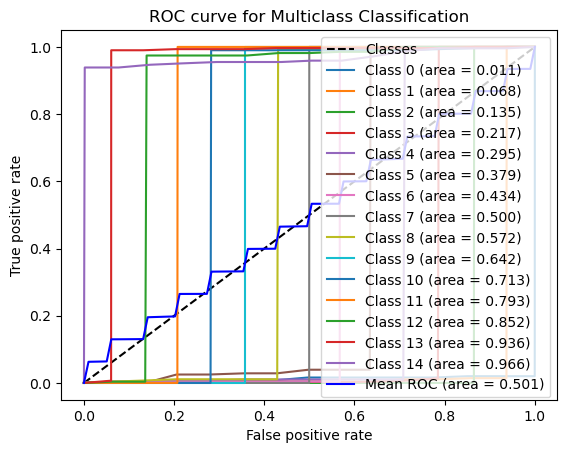

Training Start with svm_model


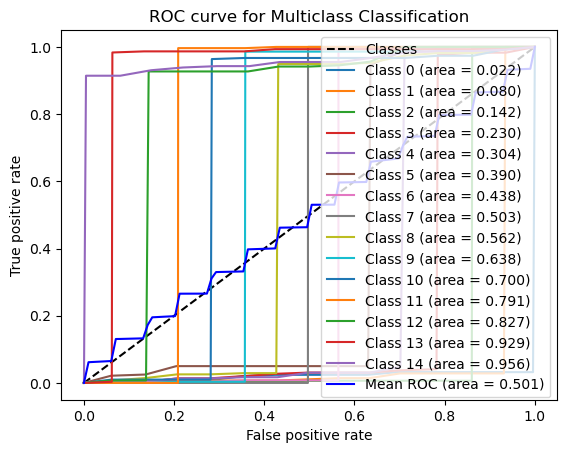

Training Start with logistic_regression_model


c:\conda\envs\dl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


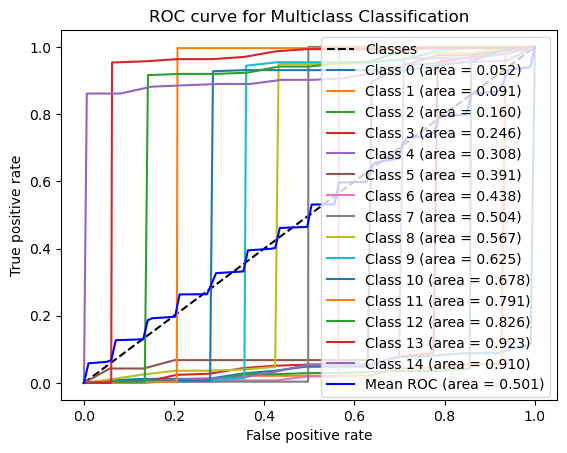

Training Start with xgb_model


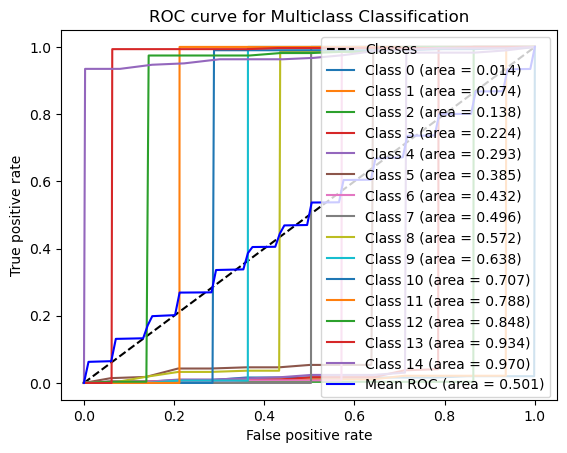


      Machine Learning Models
      -------------------------
      accuracy of random forest 0.9835870599429115
      accuracy of SVM 0.9574215033301617
      accuracy of Logistic Regression 0.9188867745004757
      accuracy of XGB 0.9745480494766888
# 


In [7]:
X_train_feature, X_test_feature, y_train_feature, y_test_feature = feature_data_load(color_features,texture_features, labels)
random_forest = random_forest_model(X_train_feature, X_test_feature, y_train_feature, y_test_feature)
svm = svm_model(X_train_feature, X_test_feature, y_train_feature, y_test_feature)
logistic_regression = logistic_regression_model(X_train_feature, X_test_feature, y_train_feature, y_test_feature)
xgb = xgb_model(X_train_feature, X_test_feature, y_train_feature, y_test_feature)

print(f"""
      Machine Learning Models
      -------------------------
      accuracy of random forest {random_forest}
      accuracy of SVM {svm}
      accuracy of Logistic Regression {logistic_regression}
      accuracy of XGB {xgb}
# """)

Training Start with vgg16_model
Epoch 1/30
526/526 [==============================] - 232s 439ms/step - loss: 0.4399 - accuracy: 0.8602 - val_loss: 0.1781 - val_accuracy: 0.9451
Epoch 2/30
526/526 [==============================] - 245s 467ms/step - loss: 0.2042 - accuracy: 0.9354 - val_loss: 0.1506 - val_accuracy: 0.9508
Epoch 3/30
526/526 [==============================] - 245s 465ms/step - loss: 0.1549 - accuracy: 0.9492 - val_loss: 0.1239 - val_accuracy: 0.9619
Epoch 4/30
526/526 [==============================] - 244s 464ms/step - loss: 0.1314 - accuracy: 0.9556 - val_loss: 0.1037 - val_accuracy: 0.9684
Epoch 5/30
526/526 [==============================] - 238s 452ms/step - loss: 0.1162 - accuracy: 0.9633 - val_loss: 0.0828 - val_accuracy: 0.9736
Epoch 6/30
526/526 [==============================] - 229s 434ms/step - loss: 0.1038 - accuracy: 0.9668 - val_loss: 0.0738 - val_accuracy: 0.9774
Epoch 7/30
526/526 [==============================] - 228s 433ms/step - loss: 0.1007 - accur

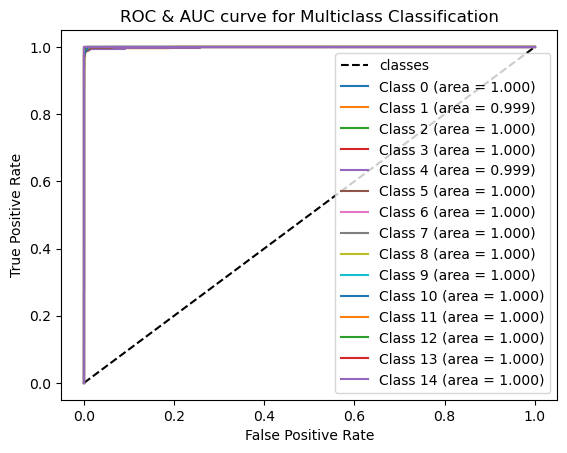

Training Start with vgg19_model
Epoch 1/30
526/526 [==============================] - 300s 567ms/step - loss: 0.5102 - accuracy: 0.8469 - val_loss: 0.2335 - val_accuracy: 0.9267
Epoch 2/30
526/526 [==============================] - 300s 571ms/step - loss: 0.2447 - accuracy: 0.9202 - val_loss: 0.2248 - val_accuracy: 0.9267
Epoch 3/30
526/526 [==============================] - 300s 571ms/step - loss: 0.1925 - accuracy: 0.9367 - val_loss: 0.1512 - val_accuracy: 0.9520
Epoch 4/30
526/526 [==============================] - 302s 574ms/step - loss: 0.1587 - accuracy: 0.9467 - val_loss: 0.1216 - val_accuracy: 0.9638
Epoch 5/30
526/526 [==============================] - 298s 567ms/step - loss: 0.1576 - accuracy: 0.9492 - val_loss: 0.1261 - val_accuracy: 0.9584
Epoch 6/30
526/526 [==============================] - 300s 571ms/step - loss: 0.1385 - accuracy: 0.9536 - val_loss: 0.1050 - val_accuracy: 0.9657
Epoch 7/30
526/526 [==============================] - 299s 568ms/step - loss: 0.1203 - accur

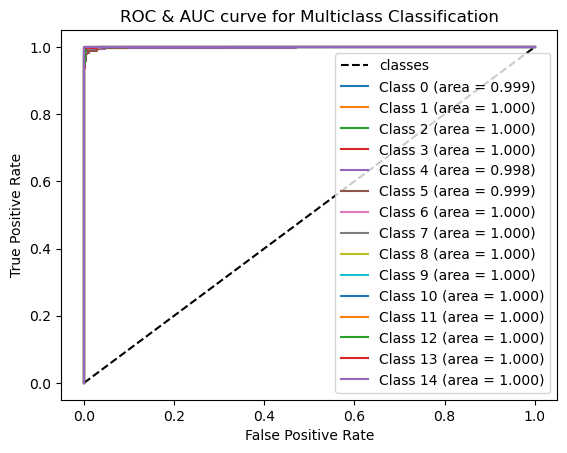

Training Start with resnet50_model
Epoch 1/30
526/526 [==============================] - 119s 220ms/step - loss: 1.5403 - accuracy: 0.5081 - val_loss: 1.1926 - val_accuracy: 0.6044
Epoch 2/30
526/526 [==============================] - 114s 216ms/step - loss: 1.1422 - accuracy: 0.6329 - val_loss: 1.0017 - val_accuracy: 0.6775
Epoch 3/30
526/526 [==============================] - 115s 218ms/step - loss: 1.0246 - accuracy: 0.6655 - val_loss: 0.9089 - val_accuracy: 0.7036
Epoch 4/30
526/526 [==============================] - 118s 225ms/step - loss: 0.9602 - accuracy: 0.6905 - val_loss: 0.8968 - val_accuracy: 0.7058
Epoch 5/30
526/526 [==============================] - 120s 228ms/step - loss: 0.9043 - accuracy: 0.7087 - val_loss: 0.8084 - val_accuracy: 0.7424
Epoch 6/30
526/526 [==============================] - 118s 225ms/step - loss: 0.8859 - accuracy: 0.7081 - val_loss: 0.8050 - val_accuracy: 0.7379
Epoch 7/30
526/526 [==============================] - 115s 218ms/step - loss: 0.8568 - ac

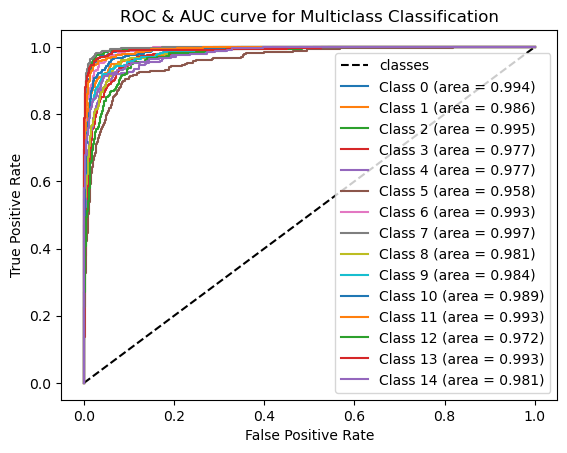

Training Start with denseNet121_model
Epoch 1/30
526/526 [==============================] - 149s 272ms/step - loss: 0.6759 - accuracy: 0.8045 - val_loss: 0.2818 - val_accuracy: 0.9132
Epoch 2/30
526/526 [==============================] - 138s 263ms/step - loss: 0.3274 - accuracy: 0.8983 - val_loss: 0.1954 - val_accuracy: 0.9403
Epoch 3/30
526/526 [==============================] - 133s 252ms/step - loss: 0.2599 - accuracy: 0.9187 - val_loss: 0.1992 - val_accuracy: 0.9410
Epoch 4/30
526/526 [==============================] - 135s 257ms/step - loss: 0.2374 - accuracy: 0.9249 - val_loss: 0.2053 - val_accuracy: 0.9374
Epoch 5/30
526/526 [==============================] - 145s 276ms/step - loss: 0.2143 - accuracy: 0.9318 - val_loss: 0.1451 - val_accuracy: 0.9605
Epoch 6/30
526/526 [==============================] - 132s 251ms/step - loss: 0.1887 - accuracy: 0.9399 - val_loss: 0.2039 - val_accuracy: 0.9370
Epoch 7/30
526/526 [==============================] - 133s 253ms/step - loss: 0.1790 -

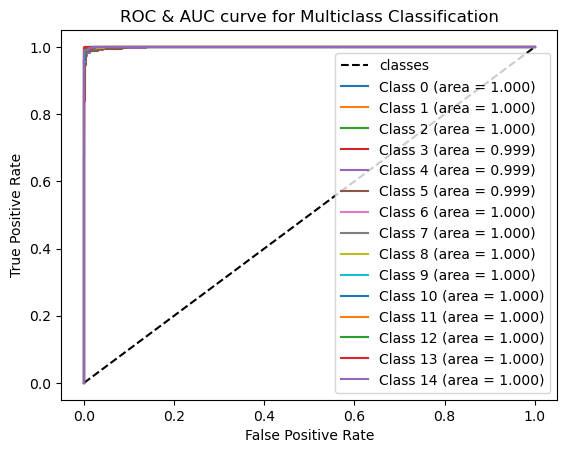

Training Start with mobilenet_model
Epoch 1/30
526/526 [==============================] - 43s 78ms/step - loss: 0.6432 - accuracy: 0.7976 - val_loss: 0.3458 - val_accuracy: 0.8953
Epoch 2/30
526/526 [==============================] - 40s 76ms/step - loss: 0.3485 - accuracy: 0.8875 - val_loss: 0.2774 - val_accuracy: 0.9132
Epoch 3/30
526/526 [==============================] - 40s 76ms/step - loss: 0.3015 - accuracy: 0.9023 - val_loss: 0.2267 - val_accuracy: 0.9341
Epoch 4/30
526/526 [==============================] - 39s 73ms/step - loss: 0.2628 - accuracy: 0.9177 - val_loss: 0.2297 - val_accuracy: 0.9284
Epoch 5/30
526/526 [==============================] - 39s 75ms/step - loss: 0.2349 - accuracy: 0.9275 - val_loss: 0.2250 - val_accuracy: 0.9315
Epoch 6/30
526/526 [==============================] - 39s 74ms/step - loss: 0.2329 - accuracy: 0.9230 - val_loss: 0.2312 - val_accuracy: 0.9334
Epoch 7/30
526/526 [==============================] - 39s 75ms/step - loss: 0.2324 - accuracy: 0.926

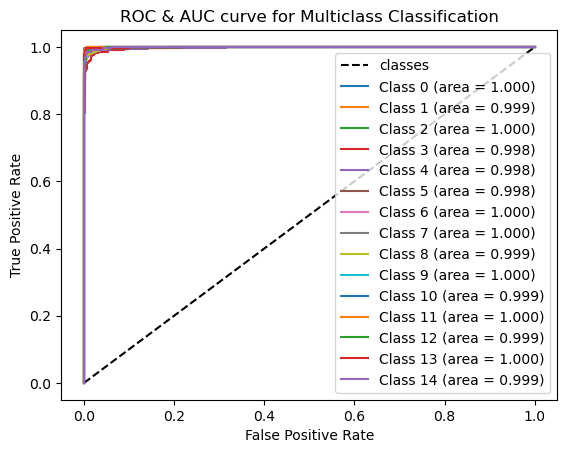


      Deep Learning Models
      --------------------
      accuracy of vgg16_accuracy: 0.9892958998680115
      accuracy of vgg19_accuracy: 0.982397735118866
      accuracy of resnet50_accuracy: 0.7961465120315552
      accuracy of denseNet121_accuracy: 0.9766888618469238
      accuracy of mobilenet_accuracy: 0.9686013460159302



In [8]:
X_train_img, X_test_img, y_train_img, y_test_img = image_data_load(images, labels)
vgg16_accuracy = model_training("vgg16",X_train_img, X_test_img, y_train_img, y_test_img)
vgg19_accuracy = model_training("vgg19",X_train_img, X_test_img, y_train_img, y_test_img)
resnet50_accuracy = model_training("resnet50",X_train_img, X_test_img, y_train_img, y_test_img)
denseNet121_accuracy = model_training("denseNet121",X_train_img, X_test_img, y_train_img, y_test_img)
mobilenet_accuracy = model_training("mobilenet",X_train_img, X_test_img, y_train_img, y_test_img)



print(f"""
      Deep Learning Models
      --------------------
      accuracy of vgg16_accuracy: {vgg16_accuracy[1]}
      accuracy of vgg19_accuracy: {vgg19_accuracy[1]}
      accuracy of resnet50_accuracy: {resnet50_accuracy[1]}
      accuracy of denseNet121_accuracy: {denseNet121_accuracy[1]}
      accuracy of mobilenet_accuracy: {mobilenet_accuracy[1]}
""")

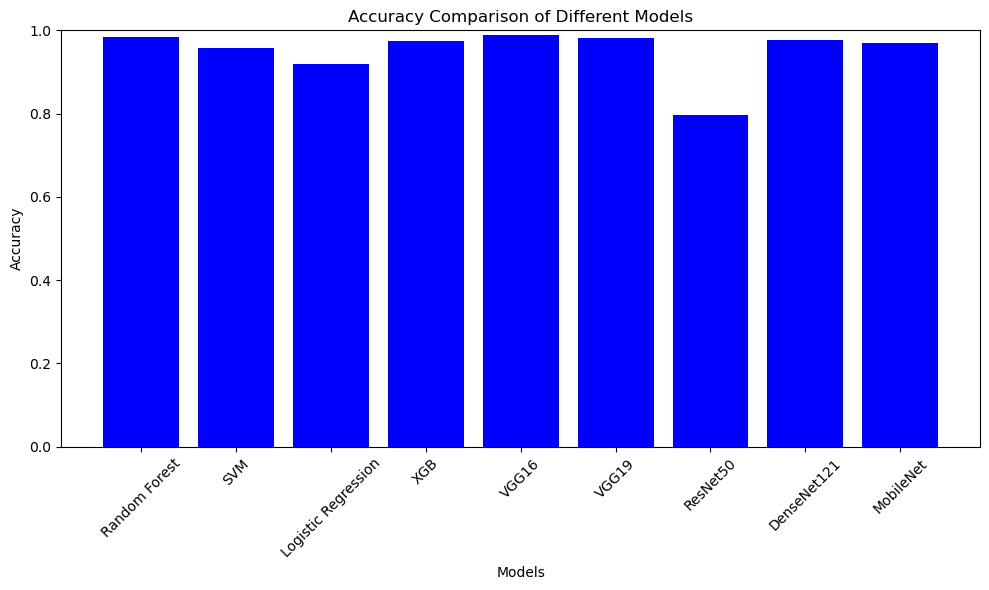

In [9]:
import matplotlib.pyplot as plt

# List of model names
model_names = ['Random Forest', 'SVM', 'Logistic Regression', 'XGB', 'VGG16', 'VGG19', 'ResNet50', 'DenseNet121', 'MobileNet']

# List of accuracies
accuracies = [random_forest, svm, logistic_regression, xgb, vgg16_accuracy[1], vgg19_accuracy[1], resnet50_accuracy[1], denseNet121_accuracy[1], mobilenet_accuracy[1]]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='blue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Adjust the y-axis limits as needed
plt.tight_layout()

# Display the bar chart
plt.show()
                                                                                                    